In [1]:
import pandas as pd




from sklearn.model_selection import train_test_split


from wordcloud import WordCloud

import matplotlib.pyplot as plt

from itertools import chain
import pyLDAvis.gensim_models
import gensim

from gensim.models import CoherenceModel
%matplotlib inline

In [2]:
df = pd.read_parquet('clean_v1.parquet')
df.head()

Title  \
0                      find malloc double free error   
1                 mock asp.netmvc controller context   
2                                  list symbols file   
3  main performance differences varchar nvarchar ...   
4                            highpass lowpass filter   

                                                Body      Id  \
0  program application objectivec get error myapp...  971249   
1  controller context depend asp.net internals wa...   32640   
2  list symbols export file possible would also l...   34732   
3  work database small web app school use sql ser...   35366   
4  graphics audio edit process software often con...   35530   

                                   Tags  Score  ViewCount  AnswerCount  \
0  iphone objective-c memory-management     82      79057           13   
1      asp.net-mvc unit-testing mocking     70      48431            7   
2                             c++ c gcc    594     512500           11   
3            sql-server sql-server-2005    247     182380           14   
4                       algorithm audio     27      85513            6   

   FavoriteCount                                    Title_not_clean  \
0            0.0  how to find the cause of a malloc "double free...   
1            0.0             mocking asp.net-mvc controller context   
2            0.0            how do i list the symbols in a .so file   
3            0.0  what are the main performance differences betw...   
4            0.0           what are high-pass and low-pass filters?   

                                      Body_not_clean  
0  i'm programming an application in objective-c ...  
1  so the controller context depends on some asp....  
2  how do i list the symbols being exported from ...  
3  i'm working on a database for a small web app ...  
4  graphics and audio editing and processing soft...

In [3]:
SEED = 42

In [4]:
X = df['Title'] # + " " + df["Body"]
y = df['Tags']
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=SEED
)
print(f"Train : {X_train.shape}", f"Test : {X_test.shape}")

Train : (47001,) Test : (15668,)


In [5]:
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [6]:
train_processed_docs = [doc.split() for doc in X_train]
len(train_processed_docs)

47001

In [7]:
test_processed_docs = [doc.split() for doc in X_test]
len(test_processed_docs)

15668

In [8]:
dictionary = gensim.corpora.Dictionary(train_processed_docs)

In [9]:
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n=1000)

In [10]:
train_corpus = [dictionary.doc2bow(doc) for doc in train_processed_docs]
test_corpus = [dictionary.doc2bow(doc) for doc in test_processed_docs]

In [11]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, minimum_probability=0, random_state=100, passes=50, chunksize=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus))
    return perplexity_values, coherence_values, model_list


In [12]:
start = 20
limit = 150
step = 10

perplexity_values, coherence_values, all_model = compute_coherence_values(dictionary=dictionary, corpus=train_corpus, texts=train_processed_docs, start=start, limit=limit, step=step)

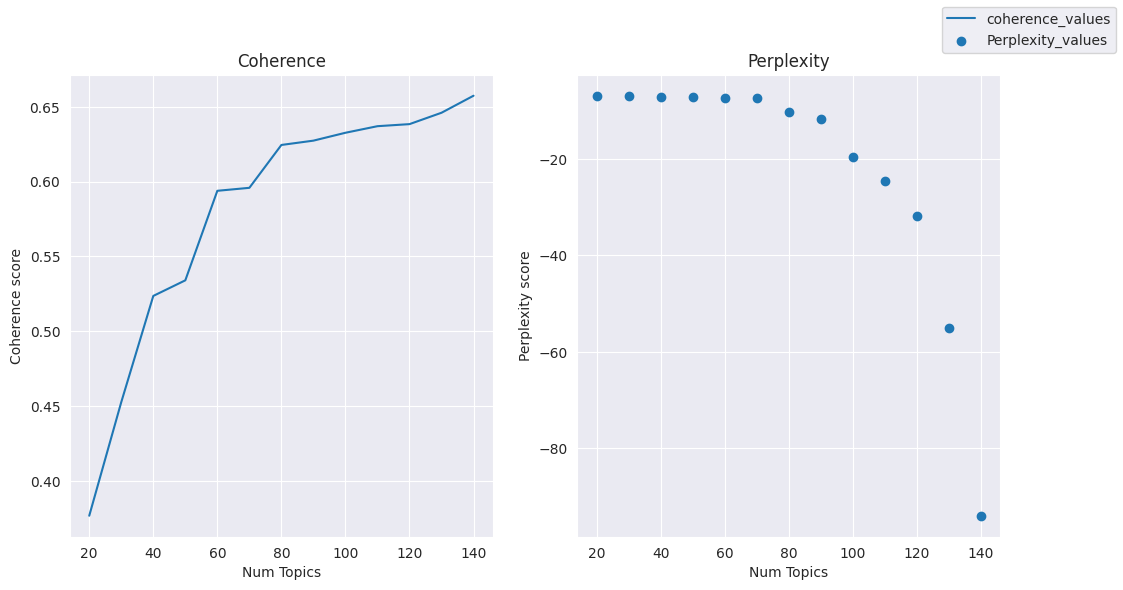

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
x = range(start, limit, step)

ax1.plot(x, coherence_values, label="coherence_values")
ax1.set_title('Coherence')
ax1.set_xlabel("Num Topics")
ax1.set_ylabel("Coherence score")

ax2.scatter(x, perplexity_values, label="Perplexity_values")
ax2.set_title('Perplexity')
ax2.set_xlabel("Num Topics")
ax2.set_ylabel("Perplexity score")
f.legend()
plt.show()

In [14]:
NUM_TOPIC = 50
lda_model = all_model[3]

In [15]:
# Get a glance at what word constitute the topics
topics = []
for idx, topic in lda_model.print_topics(-1) :
    print(f"Topic: {idx} -> Words: {topic}")
    topics.append(topic)

Topic: 0 -> Words: 0.250*"table" + 0.200*"key" + 0.055*"oracle" + 0.052*"long" + 0.048*"development" + 0.044*"hash" + 0.041*"numpy" + 0.038*"retrieve" + 0.027*"comparison" + 0.027*"row"
Topic: 1 -> Words: 0.205*"change" + 0.082*"button" + 0.073*"color" + 0.055*"row" + 0.055*"programmatically" + 0.051*"background" + 0.047*"order" + 0.036*"ajax" + 0.036*"item" + 0.035*"firebase"
Topic: 2 -> Words: 0.135*"control" + 0.131*"handle" + 0.122*"disable" + 0.101*"result" + 0.072*"address" + 0.060*"move" + 0.045*"argument" + 0.043*"launch" + 0.036*"dll" + 0.032*"admin"
Topic: 3 -> Words: 0.220*"code" + 0.209*"add" + 0.084*"generate" + 0.075*"exist" + 0.064*"delete" + 0.039*"parameter" + 0.036*"parse" + 0.035*"plugin" + 0.035*"try" + 0.028*"level"
Topic: 4 -> Words: 0.194*"html" + 0.191*"custom" + 0.095*"attribute" + 0.068*"entity" + 0.056*"width" + 0.048*"validation" + 0.040*"learn" + 0.039*"token" + 0.032*"align" + 0.032*"framework"
Topic: 5 -> Words: 0.306*"jquery" + 0.144*"map" + 0.139*"versi

In [16]:
# To dataframe
M_topics_words = []
for i in range(len(topics)):
    str = topics[i].split(' + ')
    topic_model = []
    for j in range(10):
        weight = str[j][0:5]
        word = str[j][7:len(str[j])-1]
        topic_model.append((weight, word))
    M_topics_words.append(topic_model)
df_M_topics_words = pd.DataFrame(M_topics_words)
df_M_topics_words.rename(index = {i: f"Topic {i}" for i  in range(NUM_TOPIC)})
df_M_topics_words

0                    1                    2  \
0         (0.250, table)         (0.200, key)      (0.055, oracle)   
1        (0.205, change)      (0.082, button)       (0.073, color)   
2       (0.135, control)      (0.131, handle)     (0.122, disable)   
3          (0.220, code)         (0.209, add)    (0.084, generate)   
4          (0.194, html)      (0.191, custom)   (0.095, attribute)   
5        (0.306, jquery)         (0.144, map)     (0.139, version)   
6           (0.137, two)       (0.088, click)         (0.082, xml)   
7        (0.264, python)        (0.185, work)      (0.107, method)   
8        (0.168, number)      (0.149, select)      (0.113, column)   
9       (0.117, request)       (0.085, model)      (0.080, google)   
10           (0.218, c#)         (0.199, way)        (0.112, best)   
11            (0.080, +)        (0.079, date)         (0.064, via)   
12         (0.114, user)         (0.084, wpf)    (0.078, specific)   
13       (0.149, studio)     (0.126, project)      (0.116, visual)   
14         (0.141, line)     (0.102, command)        (0.100, file)   
15        (0.237, value)    (0.162, multiple)      (0.124, return)   
16      (0.212, asp.net)         (0.144, mvc)        (0.078, give)   
17         (0.314, data)   (0.104, reference)     (0.094, display)   
18        (0.171, store)      (0.170, update)   (0.078, determine)   
19          (0.303, c++)  (0.193, difference)       (0.066, react)   
20       (0.263, create)        (0.184, test)         (0.091, css)   
21         (0.224, type)        (0.117, rail)        (0.068, like)   
22         (0.265, .net)   (0.124, framework)        (0.099, core)   
23          (0.231, sql)      (0.226, server)    (0.131, database)   
24        (0.363, error)        (0.112, fail)        (0.076, send)   
25         (0.142, base)     (0.103, message)   (0.099, exception)   
26            (0.183, x)         (0.095, mac)          (0.085, os)   
27  (0.227, application)        (0.185, view)      (0.100, detect)   
28            (0.177, c)   (0.121, implement)        (0.118, open)   
29        (0.406, class)      (0.155, inside)  (0.043, objectivec)   
30           (0.226, vs)        (0.079, link)     (0.073, support)   
31       (0.279, string)       (0.192, array)      (0.107, remove)   
32          (0.236, ios)      (0.091, iphone)        (0.061, hide)   
33     (0.181, function)  (0.141, javascript)      (0.090, access)   
34          (0.217, run)     (0.106, service)      (0.090, format)   
35      (0.321, android)         (0.199, app)         (0.114, web)   
36          (0.194, set)     (0.134, windows)      (0.114, cannot)   
37        (0.128, swift)     (0.121, content)        (0.089, warn)   
38         (0.168, page)        (0.138, pass)       (0.092, match)   
39     (0.147, possible)         (0.142, new)         (0.088, url)   
40       (0.107, scroll)          (0.093, id)         (0.086, div)   
41         (0.137, make)         (0.133, php)        (0.131, name)   
42        (0.165, check)         (0.146, api)     (0.128, element)   
43      (0.115, eclipse)    (0.100, elements)         (0.100, tag)   
44         (0.148, size)         (0.109, get)        (0.097, need)   
45         (0.230, find)     (0.150, convert)        (0.129, time)   
46         (0.219, list)        (0.183, text)       (0.096, linux)   
47         (0.404, java)       (0.101, write)      (0.080, spring)   
48        (0.235, image)        (0.146, load)        (0.110, show)   
49       (0.211, object)        (0.142, call)         (0.127, one)   

                       3                          4                        5  \
0          (0.052, long)       (0.048, development)            (0.044, hash)   
1           (0.055, row)  (0.055, programmatically)      (0.051, background)   
2        (0.101, result)           (0.072, address)            (0.060, move)   
3         (0.075, exist)            (0.064, delete)       (0.039, parameter)   
4        (0.068, entity)             (0.056, width) 

## Visualisation du modèle

In [17]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, train_corpus, dictionary)

/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7      0.013868 -0.066634       1        1  2.960779
33     0.020066  0.027393       2        1  2.910708
41    -0.080884 -0.113272       3        1  2.830870
10    -0.021814 -0.056428       4        1  2.819428
15     0.116733 -0.068038       5        1  2.673599
49    -0.087591 -0.069686       6        1  2.610897
36    -0.130895  0.042682       7        1  2.593622
1     -0.014492 -0.073787       8        1  2.539072
3     -0.102247  0.011395       9        1  2.382657
14    -0.222538 -0.011489      10        1  2.318354
45    -0.109536 -0.002054      11        1  2.305540
20    -0.086174  0.068780      12        1  2.299263
31    -0.008094 -0.029047      13        1  2.260291
35     0.103378 -0.076999      14        1  2.226205
21    -0.002933  0.004241      15        1  2.198961
11     0.002385 -0.082399      16        1  2.198092
9      0.052153 -0.128167      17        1  2.178538
13     0.048967  0.095343      18        1  2.123401
30     0.044110  0.133194      19        1  2.116669
46     0.024036 -0.112200      20        1  2.082128
47    -0.086576 -0.081920      21        1  2.055049
24     0.066691 -0.037512      22        1  2.046285
32     0.075259  0.081789      23        1  2.030654
34     0.082014 -0.024999      24        1  2.014896
48    -0.098604  0.047982      25        1  2.007110
23    -0.043010  0.080246      26        1  1.951736
12    -0.130560  0.056197      27        1  1.933538
8      0.112374 -0.060349      28        1  1.900449
6     -0.025786  0.070830      29        1  1.883855
27     0.049969  0.109545      30        1  1.843635
17     0.106314 -0.044614      31        1  1.818095
42    -0.154641  0.042949      32        1  1.787891
16    -0.010819 -0.046198      33        1  1.767198
19     0.047339  0.104086      34        1  1.754970
39     0.105128 -0.021330      35        1  1.750892
28    -0.174441  0.030731      36        1  1.694556
4      0.103202  0.014497      37        1  1.688947
38     0.045019  0.107134      38        1  1.659853
44    -0.036446 -0.205498      39        1  1.628856
0      0.066913  0.111505      40        1  1.618087
25     0.052224  0.120719      41        1  1.557300
18    -0.028024  0.104382      42        1  1.548157
29     0.010226  0.106231      43        1  1.490711
37     0.013129 -0.089611      44        1  1.482217
43     0.057245  0.118426      45        1  1.468450
5      0.099502 -0.014397      46        1  1.445892
2      0.033099 -0.084982      47        1  1.422060
40     0.106251 -0.098867      48        1  1.416236
22     0.070513  0.105843      49        1  1.379926
26    -0.072002 -0.095643      50        1  1.323427, topic_info=            Term         Freq        Total Category  logprob  loglift
44          java  1507.000000  1507.000000  Default  30.0000  30.0000
69         error  1349.000000  1349.000000  Default  29.0000  29.0000
46        python  1418.000000  1418.000000  Default  28.0000  28.0000
127      android  1298.000000  1298.000000  Default  27.0000  27.0000
91         class  1099.000000  1099.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
6           page     0.022758   506.477499  Topic50 -11.5664  -5.6854
7       solution     0.022758   103.372955  Topic50 -11.5664  -4.0962
8    application     0.022758   758.836883  Topic50 -11.5664  -6.0897
9             c#     0.022758  1115.862795  Topic50 -11.5664  -6.4753
10         embed     0.022758   163.531338  Topic50 -11.5664  -4.5549

[1927 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
269      16  0.997495         +
266      49  0.998431      .net
765      43  0.976474  abstract
663      45  0.988766    accept
79        2  0.996874    access
...     ...       ...       ...
196      44  0.144318     xcode
495      29  0.995119       xml
839

### Evaluating the model clustering

#### Training

In [18]:
# Train questions
data_dict = {'Dominant_Topic':[], 'Perc_Contribution':[], 'Topic_keywords':[]}

for i, row in enumerate(lda_model[train_corpus]):
    row = sorted(row, key=lambda x: x[1], reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        wp = lda_model.show_topic(topic_num)
        topic_keywords = [(float(weight) , word) for word, weight in wp]
        data_dict['Dominant_Topic'].append(int(topic_num))
        data_dict['Perc_Contribution'].append(round(prop_topic, 3))
        data_dict['Topic_keywords'].append(topic_keywords)

        break

df_topics = pd.DataFrame(data_dict)

df_topics['Title'] = X_train
df_topics['Real_tags'] = y_train
df_topics

Dominant_Topic  Perc_Contribution  \
0                  40              0.224   
1                  13              0.289   
2                  23              0.340   
3                  17              0.336   
4                  33              0.510   
...               ...                ...   
46996               5              0.255   
46997              45              0.340   
46998               0              0.020   
46999              44              0.204   
47000              23              0.170   

                                          Topic_keywords  \
0      [(0.10688307136297226, scroll), (0.09304313361...   
1      [(0.14938436448574066, studio), (0.12573185563...   
2      [(0.2305789738893509, sql), (0.225621983408927...   
3      [(0.31379032135009766, data), (0.1035327836871...   
4      [(0.18103890120983124, function), (0.140627413...   
...                                                  ...   
46996  [(0.30565375089645386, jquery), (0.14444541931...   
46997  [(0.23016375303268433, find), (0.1496127843856...   
46998  [(0.25040191411972046, table), (0.200351774692...   
46999  [(0.14769500494003296, size), (0.1088758856058...   
47000  [(0.2305789738893509, sql), (0.225621983408927...   

                                                   Title        Real_tags  
0      programmatic solution change navigation id hig...      asp.net css  
1            embed font c# application use visual studio               c#  
2                calculate systemdecimal precision scale             .net  
3      iso c++ forbid forward reference enum type spe...              c++  
4             extend indexcontroller basecontroller zend        php class  
...                                                  ...              ...  
46996                       case choose katalon selenium    java selenium  
46997  lubridate week find consecutive week number mu...                r  
46998                              explanation blob clob       sql oracle  
46999                     character need escape use bash  bash shell unix  
47000  problems generate sql via eclipselink miss sep...     java sql jpa  

[47001 rows x 5 columns]

In [19]:
M_train_quest_words = df_topics.apply(lambda x : [(prob_word[0]*x["Perc_Contribution"], prob_word[1]) for prob_word in x['Topic_keywords']], axis=1)
M_train_quest_words

0        [(0.023941808724310176, scroll), (0.0208416625...
1        [(0.0431720820130832, studio), (0.036336506846...
2        [(0.07839685194699397, sql), (0.07671147516592...
3        [(0.1054335465521774, data), (0.03478701484987...
4        [(0.09232983789049243, function), (0.071719979...
                               ...                        
46996    [(0.07794170502112507, jquery), (0.03683358123...
46997    [(0.0782556768542424, find), (0.05086834722618...
46998    [(0.005008038170456031, table), (0.00400703540...
46999    [(0.030129780444354992, size), (0.022210680248...
47000    [(0.039198425973496986, sql), (0.0383557375829...
Length: 47001, dtype: object

In [20]:
# Find the threshold, let's set the threshold to be 1/#clusters,
# To prove that the threshold is sane, we average the sum of all probabilities:
scores = list(chain(*[[score for topic_id,score in topic]
                      for topic in [doc for doc in lda_model[train_corpus]]]))
threshold = sum(scores)/len(scores)
print(threshold)

0.019999999893370195


In [21]:
df_topics['Proposed_tags'] = M_train_quest_words.apply(lambda x : [i[1] for i in x if i[0] > threshold])

In [22]:
# As we can see some proposed tags are empty
df_topics.sample(20)

Dominant_Topic  Perc_Contribution  \
33672              41              0.505   
16553              24              0.337   
44146              27              0.146   
41757               9              0.146   
29331              33              0.289   
43930               9              0.255   
14806              12              0.404   
1896               32              0.255   
6888               46              0.170   
35678              15              0.505   
715                42              0.302   
27092              36              0.670   
26830              10              0.340   
42837              21              0.255   
17250               3              0.146   
4742               23              0.404   
34030              48              0.252   
28329              31              0.505   
1915               22              0.510   
7351               49              0.170   

                                          Topic_keywords  \
33672  [(0.13665235042572021, make), (0.1328034102916...   
16553  [(0.36324796080589294, error), (0.111957490444...   
44146  [(0.22658966481685638, application), (0.184911...   
41757  [(0.11654452234506607, request), (0.0846946761...   
29331  [(0.18103890120983124, function), (0.140627413...   
43930  [(0.11654452234506607, request), (0.0846946761...   
14806  [(0.11425116658210754, user), (0.0836130678653...   
1896   [(0.2361491322517395, ios), (0.091494567692279...   
6888   [(0.21866349875926971, list), (0.1827343106269...   
35678  [(0.23703663051128387, value), (0.162072777748...   
715    [(0.16481885313987732, check), (0.146061822772...   
27092  [(0.19430401921272278, set), (0.13353301584720...   
26830  [(0.21797023713588715, c#), (0.199496477842330...   
42837  [(0.22384727001190186, type), (0.1174716353416...   
17250  [(0.22024139761924744, code), (0.2087194919586...   
4742   [(0.2305789738893509, sql), (0.225621983408927...   
34030  [(0.23462001979351044, image), (0.145980432629...   
28329  [(0.27918338775634766, string), (0.19180054962...   
1915   [(0.26526597142219543, .net), (0.1237668767571...   
7351   [(0.210519939661026, object), (0.1421692222356...   

                                                   Title  \
33672                                  speed maven build   
16553  sql network interfaces error error locate serv...   
44146  problems mvc application try reference newer v...   
41757      google offer partial search index would large   
29331  grid custom command hierarchy call javascript ...   
43930                       laravel phpunit mock request   
14806          nickname common program special character   
1896                                      ios image turn   
6888         bind textblock resource contain format text   
35678                          get ascii value character   
715    pass element javascript onclick function add c...   
27092  angularuibootstraps typeahead cannot read leng...   
26830                          live flv stream c# webapi   
42837             transform lognet config like webconfig   
17250  add items user media category interface builde...   
4742                 good tool visualise database schema   
34030       docker build take long instal grpcio via pip   
28329                              check condition false   
1915                               use xpath elementtree   
7351       compare date object different level precision   

                                        Real_tags  \
33672                                     maven-2   
16553                     asp.net sql-server-2008   
44146  c# asp.net asp.net-mvc asp.net-mvc-4 razor   
41757                                      search   
29331                                  javascript   
43930                    php laravel unit-testing   
14806                           language-agnostic   
1896                    objective-c ios animation   
6888                                     wpf xaml   
35678                         

In [23]:
# Let's have a look which topics have emtpy proposed for the question
df_topics[df_topics['Proposed_tags'].str.len() == 0 ]['Dominant_Topic'].value_counts()

0     837
11     74
9      33
12     28
41     27
40     26
43     20
37     14
2      11
39      9
44      3
14      3
8       2
6       2
42      2
16      1
4       1
38      1
28      1
13      1
25      1
36      1
30      1
Name: Dominant_Topic, dtype: int64

In [24]:
df_topics[(df_topics['Proposed_tags'].str.len() != 0) & (df_topics['Dominant_Topic'] == 0)]

Dominant_Topic  Perc_Contribution  \
74                  0              0.255   
138                 0              0.295   
253                 0              0.255   
397                 0              0.510   
432                 0              0.146   
...               ...                ...   
46614               0              0.204   
46665               0              0.146   
46886               0              0.505   
46954               0              0.510   
46978               0              0.170   

                                          Topic_keywords  \
74     [(0.25040191411972046, table), (0.200351774692...   
138    [(0.25040191411972046, table), (0.200351774692...   
253    [(0.25040191411972046, table), (0.200351774692...   
397    [(0.25040191411972046, table), (0.200351774692...   
432    [(0.25040191411972046, table), (0.200351774692...   
...                                                  ...   
46614  [(0.25040191411972046, table), (0.200351774692...   
46665  [(0.25040191411972046, table), (0.200351774692...   
46886  [(0.25040191411972046, table), (0.200351774692...   
46954  [(0.25040191411972046, table), (0.200351774692...   
46978  [(0.25040191411972046, table), (0.200351774692...   

                                                  Title  \
74      crossbrowser extension development alternatives   
138               lazyload standard html table many row   
253    find intersect geographies two table recursively   
397                      easier bookmarklet development   
432                 check mysql table column even exist   
...                                                 ...   
46614                optimize oracle connect use clause   
46665     drop null constraints postgresql table one go   
46886           jqueryui sortable table row shrink drag   
46954                            redis expire key daily   
46978                    check table exist statement c#   

                             Real_tags  \
74     internet-explorer google-chrome   
138         c# javascript asp.net html   
253                     sql postgresql   
397                         javascript   
432                          php mysql   
...                                ...   
46614           sql performance oracle   
46665                   sql postgresql   
46886                 jquery jquery-ui   
46954                     node.js unix   
46978                               c#   

                                           Proposed_tags  
74                                          [table, key]  
138                                         [table, key]  
253                                         [table, key]  
397    [table, key, oracle, long, development, hash, ...  
432                                         [table, key]  
...                                                  ...  
46614                                       [table, key]  
46665                                       [table, key]  
46886  [table, key, oracle, long, development, hash, ...  
46954  [table, key, oracle, long, development, hash, ...  
46978                                       [table, key]  

[763 rows x 6 columns]

In [25]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topics.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Title", "Tags", "Prop"]

# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0          0               0.698   
1          1               0.804   
2          2               0.755   
3          3               0.673   
4          4               0.755   

                                            Keywords  \
0  [(0.25040191411972046, table), (0.200351774692...   
1  [(0.20490878820419312, change), (0.08203472197...   
2  [(0.13535141944885254, control), (0.1313678622...   
3  [(0.22024139761924744, code), (0.2087194919586...   
4  [(0.19398096203804016, html), (0.1909594684839...   

                                      Title                 Tags  \
0    create foreign key without primary key  sql sql-server-2005   
1      change button color programmatically    javascript button   
2                   get ip address sockaddr          c++ sockets   
3      overwrite exist file use rubyzip lib                 ruby   
4  get custom product attribute woocommerce                  php   

                                                Prop  
0  [table, key, oracle, long, development, hash, ...  
1  [change, button, color, row, programmatically,...  
2  [control, handle, disable, result, address, mo...  
3  [code, add, generate, exist, delete, parameter...  
4  [html, custom, attribute, entity, width, valid...

In [26]:
# Number of Documents for Each Topic
topic_counts = df_topics['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topics[['Dominant_Topic', 'Topic_keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(40)

Dominant_Topic                                     Topic_Keywords  \
0               40  [(0.10688307136297226, scroll), (0.09304313361...   
1               13  [(0.14938436448574066, studio), (0.12573185563...   
2               23  [(0.2305789738893509, sql), (0.225621983408927...   
3               17  [(0.31379032135009766, data), (0.1035327836871...   
4               33  [(0.18103890120983124, function), (0.140627413...   
5                0  [(0.25040191411972046, table), (0.200351774692...   
6               26  [(0.18308626115322113, x), (0.0947538167238235...   
7               45  [(0.23016375303268433, find), (0.1496127843856...   
8               34  [(0.21701307594776154, run), (0.10593967884778...   
9               44  [(0.14769500494003296, size), (0.1088758856058...   
10              10  [(0.21797023713588715, c#), (0.199496477842330...   
11               7  [(0.26395419239997864, python), (0.18522350490...   
12              34  [(0.21701307594776154, run), (0.10593967884778...   
13              10  [(0.21797023713588715, c#), (0.199496477842330...   
14              42  [(0.16481885313987732, check), (0.146061822772...   
15              41  [(0.13665235042572021, make), (0.1328034102916...   
16              48  [(0.23462001979351044, image), (0.145980432629...   
17              21  [(0.22384727001190186, type), (0.1174716353416...   
18              16  [(0.21224617958068848, asp.net), (0.1444799602...   
19              24  [(0.36324796080589294, error), (0.111957490444...   
20               9  [(0.11654452234506607, request), (0.0846946761...   
21               8  [(0.16845576465129852, number), (0.14940254390...   
22              17  [(0.31379032135009766, data), (0.1035327836871...   
23              33  [(0.18103890120983124, function), (0.140627413...   
24              25  [(0.1417706161737442, base), (0.10317672044038...   
25              29  [(0.40632912516593933, class), (0.154756858944...   
26              35  [(0.3213414251804352, android), (0.19939740002...   
27               1  [(0.20490878820419312, change), (0.08203472197...   
28              10  [(0.21797023713588715, c#), (0.199496477842330...   
29              44  [(0.14769500494003296, size), (0.1088758856058...   
30              44  [(0.14769500494003296, size), (0.1088758856058...   
31              49  [(0.210519939661026, object), (0.1421692222356...   
32              14  [(0.14103016257286072, line), (0.1020726487040...   
33              49  [(0.210519939661026, object), (0.1421692222356...   
34              35  [(0.3213414251804352, android), (0.19939740002...   
35              48  [(0.23462001979351044, image), (0.145980432629...   
36              31  [(0.27918338775634766, string), (0.19180054962...   
37              16  [(0.21224617958068848, asp.net), (0.1444799602...   
38              18  [(0.1709810495376587, store), (0.1696594357490...   
39              36  [(0.19430401921272278, set), (0.13353301584720...   

    Num_Documents  Perc_Documents  
0          1600.0          0.0340  
1          1039.0          0.0221  
2           485.0          0.0103  
3          1194.0          0.0254  
4           807.0          0.0172  
5           854.0          0.0182  
6           587.0          0.0125  
7          2065.0          0.0439  
8           721.0          0.0153  
9           741.0          0.0158  
10         1563.0          0.0333  
11          582.0          0.0124  
12          608.0          0.0129  
13          835.0          0.0178  
14          944.0          0.0201  
15         1505.0          0.0320  
16          737.0          0.0157  
17          867.0          0.0184  
18          498.0          0.0106  
19         1163.0          0.0247  
20         1296.0          0.0276  
21         1022.0          0.0217  
22          672.0          0.0143  
23         1139.0          0.0242  
24         1116.0          0.0237  
25          402.0          0.0086  
26          471.0          0.0100  
27

In [27]:
for i, grp in sent_topics_outdf_grpd:
    print(grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1))

       Dominant_Topic  Perc_Contribution  \
25305               0              0.698   

                                          Topic_keywords  \
25305  [(0.25040191411972046, table), (0.200351774692...   

                                        Title            Real_tags  \
25305  create foreign key without primary key  sql sql-server-2005   

                                           Proposed_tags  
25305  [table, key, oracle, long, development, hash, ...  
       Dominant_Topic  Perc_Contribution  \
32255               1              0.804   

                                          Topic_keywords  \
32255  [(0.20490878820419312, change), (0.08203472197...   

                                      Title          Real_tags  \
32255  change button color programmatically  javascript button   

                                           Proposed_tags  
32255  [change, button, color, row, programmatically,...  
       Dominant_Topic  Perc_Contribution  \
45775               2     

#### Test

In [28]:
# Test questions
data_dict = {'Dominant_Topic': [], 'Perc_Contribution': [], 'Topic_keywords': []}

for i, row in enumerate(lda_model[test_corpus]):
    row = sorted(row, key=lambda x: x[1], reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        wp = lda_model.show_topic(topic_num)
        topic_keywords = [(float(weight), word) for word, weight in wp]
        data_dict['Dominant_Topic'].append(int(topic_num))
        data_dict['Perc_Contribution'].append(round(prop_topic, 3))
        data_dict['Topic_keywords'].append(topic_keywords)

        break

test_df_topics = pd.DataFrame(data_dict)

test_df_topics['Title'] = X_test
test_df_topics['Real_tags'] = y_test

test_df_topics

Dominant_Topic  Perc_Contribution  \
0                  36              0.289   
1                   9              0.340   
2                  25              0.340   
3                  13              0.404   
4                  23              0.337   
...               ...                ...   
15663               0              0.170   
15664               6              0.255   
15665              22              0.255   
15666              23              0.255   
15667              14              0.289   

                                          Topic_keywords  \
0      [(0.19430401921272278, set), (0.13353301584720...   
1      [(0.11654452234506607, request), (0.0846946761...   
2      [(0.1417706161737442, base), (0.10317672044038...   
3      [(0.14938436448574066, studio), (0.12573185563...   
4      [(0.2305789738893509, sql), (0.225621983408927...   
...                                                  ...   
15663  [(0.25040191411972046, table), (0.200351774692...   
15664  [(0.1371048241853714, two), (0.087612345814704...   
15665  [(0.26526597142219543, .net), (0.1237668767571...   
15666  [(0.2305789738893509, sql), (0.225621983408927...   
15667  [(0.14103016257286072, line), (0.1020726487040...   

                                                   Title          Real_tags  
0                force jupyter notebook open web browser         python ssh  
1      djangooauthtoolkit customize authenticate resp...      python django  
2                           detail appcrash message mean                 c#  
3                     way export shortcuts visual studio      visual-studio  
4            appfabric cache perform x slower sql server     c# performance  
...                                                  ...                ...  
15663                     sql query count multiple table         sql oracle  
15664                   close vselect click outside vapp  javascript vue.js  
15665              zend framework pdf multiline problems            php pdf  
15666                                  use like join sql          mysql sql  
15667  squid forward another proxy authentication det...     authentication  

[15668 rows x 5 columns]

In [29]:
M_test_quest_words = test_df_topics.apply(
    lambda x: [(prob_word[0] * x["Perc_Contribution"], prob_word[1]) for prob_word in x['Topic_keywords']], axis=1)
M_test_quest_words

0        [(0.05615386243266496, set), (0.03859104218474...
1        [(0.039625138014118155, request), (0.028796190...
2        [(0.04820201000608426, base), (0.0350800853187...
3        [(0.060351285353583695, studio), (0.0507956714...
4        [(0.07770511705937544, sql), (0.07603461120601...
                               ...                        
15663    [(0.04256832584810599, table), (0.034059802055...
15664    [(0.03496172951350296, two), (0.02234114776498...
15665    [(0.06764282144777312, .net), (0.0315605529829...
15666    [(0.05879763724229825, sql), (0.05753360469342...
15667    [(0.040757717622416756, line), (0.029498995937...
Length: 15668, dtype: object

In [30]:
scores = list(chain(*[[score for topic_id, score in topic]
                      for topic in [doc for doc in lda_model[test_corpus]]]))
threshold = sum(scores) / len(scores)
print(threshold)

0.019999999892240633


In [31]:
test_df_topics['Proposed_tags'] = M_test_quest_words.apply(lambda x: [i[1] for i in x if i[0] > threshold])
test_df_topics

Dominant_Topic  Perc_Contribution  \
0                  36              0.289   
1                   9              0.340   
2                  25              0.340   
3                  13              0.404   
4                  23              0.337   
...               ...                ...   
15663               0              0.170   
15664               6              0.255   
15665              22              0.255   
15666              23              0.255   
15667              14              0.289   

                                          Topic_keywords  \
0      [(0.19430401921272278, set), (0.13353301584720...   
1      [(0.11654452234506607, request), (0.0846946761...   
2      [(0.1417706161737442, base), (0.10317672044038...   
3      [(0.14938436448574066, studio), (0.12573185563...   
4      [(0.2305789738893509, sql), (0.225621983408927...   
...                                                  ...   
15663  [(0.25040191411972046, table), (0.200351774692...   
15664  [(0.1371048241853714, two), (0.087612345814704...   
15665  [(0.26526597142219543, .net), (0.1237668767571...   
15666  [(0.2305789738893509, sql), (0.225621983408927...   
15667  [(0.14103016257286072, line), (0.1020726487040...   

                                                   Title          Real_tags  \
0                force jupyter notebook open web browser         python ssh   
1      djangooauthtoolkit customize authenticate resp...      python django   
2                           detail appcrash message mean                 c#   
3                     way export shortcuts visual studio      visual-studio   
4            appfabric cache perform x slower sql server     c# performance   
...                                                  ...                ...   
15663                     sql query count multiple table         sql oracle   
15664                   close vselect click outside vapp  javascript vue.js   
15665              zend framework pdf multiline problems            php pdf   
15666                                  use like join sql          mysql sql   
15667  squid forward another proxy authentication det...     authentication   

                                           Proposed_tags  
0                  [set, windows, cannot, read, default]  
1                   [request, model, google, save, http]  
2                      [base, message, exception, throw]  
3      [studio, project, visual, query, style, connec...  
4       [sql, server, database, process, import, insert]  
...                                                  ...  
15663                                       [table, key]  
15664                            [two, click, xml, null]  
15665                            [.net, framework, core]  
15666                   [sql, server, database, process]  
15667                     [line, command, file, library]  

[15668 rows x 6 columns]

In [32]:
test_df_topics[test_df_topics['Proposed_tags'].str.len() == 0 ]['Dominant_Topic'].value_counts()

0     314
11     25
12     14
41     11
37      8
9       8
40      5
2       4
43      4
39      3
44      2
6       1
38      1
14      1
8       1
Name: Dominant_Topic, dtype: int64